In [6]:
from datetime import datetime, timedelta
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import matplotlib.pyplot as plt

# establish connection to MetaTrader 5 terminal
if not mt5.initialize(login=93743634, server="MetaQuotes-Demo",password="*4VqApIo"):
    print("initialize() failed, error code =",mt5.last_error())
    quit()

symbols = [ 'NVDA', 'GOOGL']

# Define timeframe and number of days
timeframe = mt5.TIMEFRAME_H1  # Minute timeframe
n_days = 1200
utc_to = datetime.now()
utc_from = utc_to - timedelta(days=n_days)

# download historical data for each symbol
data = {}

for symbol in symbols:
    # Make sure the symbol is available in Market Watch
    mt5.symbol_select(symbol, True)
    
    # Get historical rates
    rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_to)
    
    if rates is None or len(rates) == 0:
        print(f"No data for {symbol}.")
        continue

    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    data[symbol] = df['close']

# Shutdown MT5 connection
mt5.shutdown()

# Combine into one DataFrame
prices = pd.concat(data.values(), axis=1)
prices.columns = data.keys()
prices.dropna(inplace=True)

data = prices
print(data.columns)  # Add this line to inspect columns

# Drop any rows with missing values
data.dropna(inplace=True)

# Create matrix for the test (log prices help with stationarity assumptions)
log_prices = data.apply(np.log)

print(f"Number of observations: {log_prices.shape[0]}")
print(f"Number of variables: {log_prices.shape[1]}")

# Check if there are enough observations for the test 
if log_prices.shape[0] < 30 or log_prices.shape[1] < 2:
    print("Not enough data for Johansen test.") 
    quit()

# Johansen Cointegration test
# det_order=0 means no deterministic trend, 
# k_ar_diff=1 is the number of lags in the VAR model
johansen_result = coint_johansen(log_prices, det_order=0, k_ar_diff=1)

# Trace statistics and critical values
print("\nJohansen Test Results (Trace Statistic):")
for i, stat in enumerate(johansen_result.lr1):
    cv = johansen_result.cvt[i, 1]  # 5% critical value
    print(f"Rank {i}: Trace Stat = {stat:.2f} | 5% CV = {cv:.2f} | {'Significant' if stat > cv else 'Not significant'}")

# Engle-Granger Cointegration Test
pairs = [(a, b) for i, a in enumerate(data.columns) for j, b in enumerate(data.columns) if i < j]
results = []
for a, b in pairs:
    score, pvalue, _ = coint(data[a], data[b])
    results.append((a, b, pvalue))

results.sort(key=lambda x: x[2])
best_pair = results[0]
a, b = best_pair[0], best_pair[1]
print(f"\nMost cointegrated pair (Engle-Granger): {a} and {b} | p-value: {best_pair[2]:.4f}")


Index(['NVDA', 'GOOGL'], dtype='object')
Number of observations: 5766
Number of variables: 2

Johansen Test Results (Trace Statistic):
Rank 0: Trace Stat = 22.61 | 5% CV = 15.49 | Significant
Rank 1: Trace Stat = 0.19 | 5% CV = 3.84 | Not significant

Most cointegrated pair (Engle-Granger): NVDA and GOOGL | p-value: 0.0515


C:\Users\gavra\AppData\Local\Temp\ipykernel_7120\354355095.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]


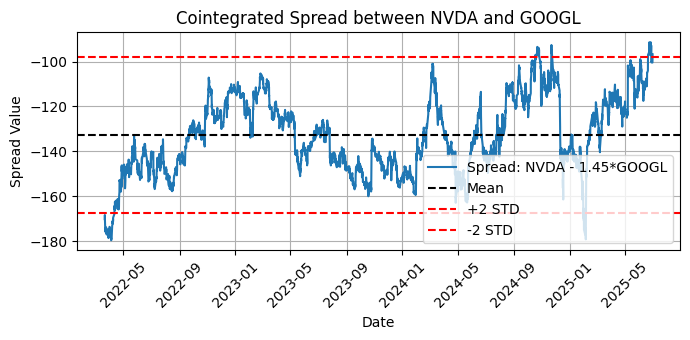

In [7]:
# estimate hedge ratio via linear regression (OLS)
import statsmodels.api as sm
X = sm.add_constant(data[b])
model = sm.OLS(data[a], X).fit()
hedge_ratio = model.params[1]

# calculate spread
spread = data[a] - hedge_ratio * data[b]

# plot
plt.figure(figsize=(7, 3.5),dpi=100)
plt.plot(spread.index, spread, label=f'Spread: {a} - {hedge_ratio:.2f}*{b}')
plt.axhline(spread.mean(), color='black', linestyle='--', label='Mean')
plt.axhline(spread.mean() + 2*spread.std(), color='red', linestyle='--', label='+2 STD')
plt.axhline(spread.mean() - 2*spread.std(), color='red', linestyle='--', label='-2 STD')
plt.title(f'Cointegrated Spread between {a} and {b}')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Spread Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# save the data to a CSV file
data.to_csv('forex_data.csv', index=True)
# save the spread to a CSV file
spread.to_csv('spread.csv', index=True)

In [8]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(spread)
print("ADF Test on Spread:")
print(f"  ADF Statistic : {adf_result[0]:.4f}")
print(f"  p-value       : {adf_result[1]:.4f}")
print(f"  Critical Values:")
for key, value in adf_result[4].items():
    print(f"    {key}: {value:.4f}")

if adf_result[1] < 0.05:
    print("\n✅ The spread is stationary (reject the null hypothesis).")
else:
    print("\n❌ The spread is NOT stationary (fail to reject the null hypothesis).")


ADF Test on Spread:
  ADF Statistic : -3.3237
  p-value       : 0.0139
  Critical Values:
    1%: -3.4315
    5%: -2.8620
    10%: -2.5670

✅ The spread is stationary (reject the null hypothesis).


In [9]:
from statsmodels.tsa.stattools import kpss

# KPSS Test
def run_kpss(series, regression='c'):
    statistic, p_value, lags, crit_values = kpss(series, regression=regression, nlags='auto')
    print("KPSS Test on Spread:")
    print(f"  KPSS Statistic : {statistic:.4f}")
    print(f"  p-value        : {p_value:.4f}")
    print(f"  Lags Used      : {lags}")
    print("  Critical Values:")
    for key, value in crit_values.items():
        print(f"    {key} : {value}")
    
    if p_value < 0.05:
        print("\n❌ The spread is NOT stationary (reject null of stationarity).")
    else:
        print("\n✅ The spread is stationary (fail to reject null of stationarity).")

# Run KPSS test on the residuals
run_kpss(spread, regression='c')  # 'c' = test for level stationarity (use 'ct' for trend)

KPSS Test on Spread:
  KPSS Statistic : 2.2053
  p-value        : 0.0100
  Lags Used      : 44
  Critical Values:
    10% : 0.347
    5% : 0.463
    2.5% : 0.574
    1% : 0.739

❌ The spread is NOT stationary (reject null of stationarity).


C:\Users\gavra\AppData\Local\Temp\ipykernel_7120\1819733679.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, lags, crit_values = kpss(series, regression=regression, nlags='auto')


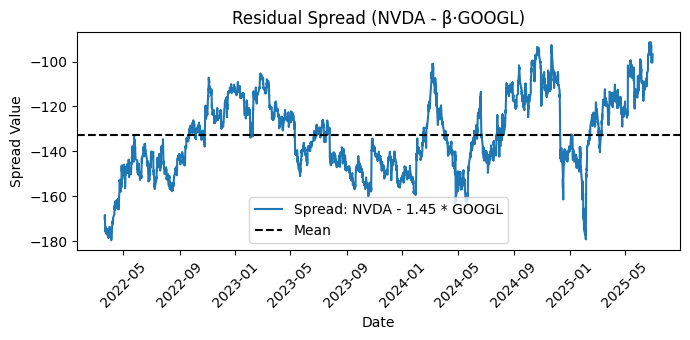

In [10]:
# plot the spread
plt.figure(figsize=(7, 3.5),dpi=100)
plt.plot(spread, label=f"Spread: NVDA - {hedge_ratio:.2f} * GOOGL")
plt.axhline(spread.mean(), color='black', linestyle='--', label='Mean')
plt.title("Residual Spread (NVDA - β·GOOGL)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Spread Value")
plt.legend()
plt.tight_layout()
plt.show()
